In [1]:
import csv
from enum import Enum
import math

# Plotting 
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
# from matplotlib.collections import Poly3DCollection # https://stackoverflow.com/questions/10599942/drawing-a-rectangle-or-bar-between-two-points-in-a-3d-scatter-plot-in-python-and
# and https://stackoverflow.com/questions/37585340/plotting-3d-polygons-in-python-3

import numpy as np
from numpy.random import PCG64
import time

# import my own libraries
from sim_loop import *          # import the simulator loop 
from drawRobot import *         # import code that plots the vehicle and arm extension
# from arm import *               # import the arm state library
# from camera import *            # import the simulated vision system
# from fruitTreeCreator import *  # import the library that creates the array with fruit location + other info
# from scheduler import *         # import the scheduler functions 
# from simulation_config import * # import the JSON creation file so that it can be read back to set parameters
# from trajectory import *        # import the trajectory generation "library" that I'm writing

import json # configuration file encode and decode
# see https://realpython.com/python-json/#decoding-custom-types

# Testing and Debugging
# Example: https://stackoverflow.com/questions/40172281/unit-tests-for-functions-in-a-jupyter-notebook
import unittest             # docs https://docs.python.org/3/library/unittest.html 
import pdb #; pdb.set_trace() # docs https://docs.python.org/3/library/pdb.html

######## RANDOM SEED GENERATOR ########
# see rand_seed.py for implementation and existing seeds

# interesting/useful websites
# talks about implementing robot simulator: https://www.toptal.com/robotics/programming-a-robot-an-introductory-tutorial  
#    said robot simulator code: https://github.com/nmccrea/sobot-rimulator/blob/v1.0.0/models/supervisor.py

In [2]:
'''Used to test the simulator and modules being exported from this code'''
sim = sim_loop()
print()

sim.sysData()
print()
sim.results() # just calculates all the results, doesn't print anything out. 

Would you like to save the JSON configurations in seperate file? (y or n)
Invalid answer, default set to not save the file.

program took: 18.49 sec
total internal time: 520.01 sec
total vehicle distance moved: 26.50 ft

vehicle speed (if constant) in the y-axis: 0.05 ft/s
max arm velocity: 1.0 ft/s, max arm acceleration: 10.0 ft/s^2
total number of fruit in CSV file: 675



In [3]:
#### STATISTICS! ####
'''Just an example of what is calculated in results()'''

print("total real reachable fruit:", sim.fruit.tot_fruit, " and reached fruit:", sim.total_fruit_picked)
print("percent reachable fruit picked:                     {0:.2f}".format(sim.all_percent_harvest*100), "%" )
print()
print("Avergage picking cycle for the system:              {0:.2f}".format(sim.all_PCT), "sec")
print("Average number of goals reach for the whole system: {0:.2f}".format(sim.all_percent_goal), "goals") # reached goals
print()

print("Seconds per picked fruit per arm", sim.sec_per_fruit, "sec/fruit")
print("")
print("Seconds per picked fruit per row", sim.row_sec_per_fruit, "sec/fruit")
print("")
print("System-wide seconds per picked fruit: {0:.2f}".format(sim.all_sec_per_fruit), "sec/fruit")
print("")


total real reachable fruit: 675  and reached fruit: 548
percent reachable fruit picked:                     81.19 %

Avergage picking cycle for the system:              5.63 sec
Average number of goals reach for the whole system: 65.83 goals

Seconds per picked fruit per arm [6.34158536584966, 9.285892857137002, 9.122982456134599, 6.2651807228876155, 13.684473684201897, 13.333589743581337, 5.977126436777841, 12.68317073169932, 8.000153846148802] sec/fruit

Seconds per picked fruit per row [2.666717948716267, 3.250062499997951, 2.694352331604519] sec/fruit

System-wide seconds per picked fruit: 0.95 sec/fruit



<IPython.core.display.Javascript object>


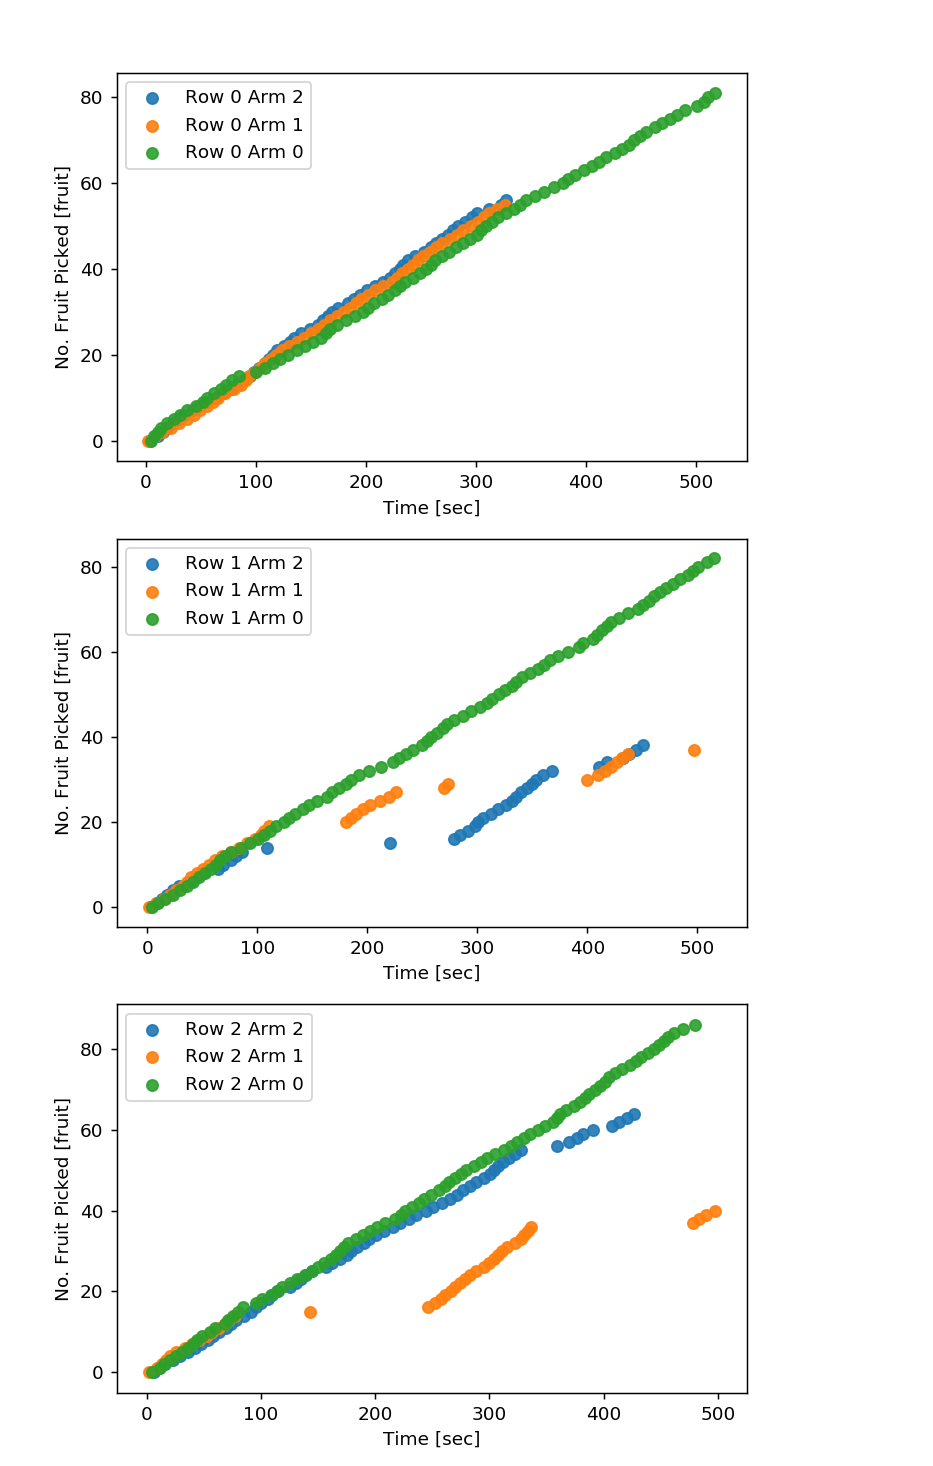

In [13]:
# Plot time versus number of fruit picked per arm
fig, ax = plt.subplots(sim.num_row, figsize=(7, 11))

for rows in range(sim.num_row):
    for manipulators in range((sim.num_arms-1), -1, -1):
        time_apples = np.copy(sim.arm_obj[rows,manipulators].pickData())
        apples      = range(np.shape(time_apples)[0])

        
        arm_label = "Row "+str(rows)+" Arm "+str(manipulators)
        
        ax[rows].scatter(time_apples, apples, alpha=0.9, label=arm_label)
        ax[rows].set_xlabel("Time [sec]")
        ax[rows].set_ylabel("No. Fruit Picked [fruit]")
#         ax[rows].set_title("No. of fruit picked versus time")
        ax[rows].legend(loc='upper left', ncol=1)
        
        fig.subplots_adjust(bottom=0.05, top=0.95, right=0.8)
        
        plt.show()
        
        

In [14]:
# for plotting
idle_plot   = []
pickyz_plot = []
pickx_plot  = []
grab_plot   = []
retr_plot   = []
unlo_plot   = [] 

for arm_state_lists in sim.states_percent:
    idle_plot.append(arm_state_lists[0])
    pickyz_plot.append(arm_state_lists[1])
    pickx_plot.append(arm_state_lists[2])
    grab_plot.append(arm_state_lists[3])
    retr_plot.append(arm_state_lists[4])
    unlo_plot.append(arm_state_lists[5])


In [15]:
## Functions to add grouping into the arm state percentage plot (and other future plots)
# https://stackoverflow.com/questions/19184484/how-to-add-group-labels-for-bar-charts-in-matplotlib

def mk_groups(data):
    # function takes a dictionary (or anything with an items() method, like collections.OrderedDict) and converts it to a data format that is then used to create the chart. It is basically a list
    try:
        newdata = data.items()
    except:
        return

    thisgroup = []
    groups = []
    for key, value in newdata:
        newgroups = mk_groups(value)
        if newgroups is None:
            thisgroup.append((key, value))
        else:
            thisgroup.append((key, len(newgroups[-1])))
            if groups:
                groups = [g + n for n, g in zip(newgroups, groups)]
            else:
                groups = newgroups
    return [thisgroup] + groups

def add_line(ax, xpos, ypos):
    # creates a vertical line in the subplot at the specified positions (in axes coordinates)
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='black')
    line.set_clip_on(False)
    ax.add_line(line)

def label_group_bar(ax, data):
    # takes a dictionary and creates the subplot with the labels beneath
    groups = mk_groups(data)
    xy = groups.pop()
    x, y = zip(*xy)
    ly = len(y)
    xticks = range(1, ly + 2)

    ax.set_xticks(xticks)
    ax.set_xticklabels(x)
    ax.set_xlim(.5, ly + .5)

    scale = 1. / ly
    for pos in range(ly + 1):
        add_line(ax, pos * scale, -.1)
        
    ypos = -.2
    while groups:
        group = groups.pop()
        pos = 0
        for label, rpos in group:
            lxpos = (pos + .5 * rpos) * scale
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes)
            add_line(ax, pos*scale, ypos)
            pos += rpos
        add_line(ax, pos*scale, ypos)
        ypos -= .1



<IPython.core.display.Javascript object>


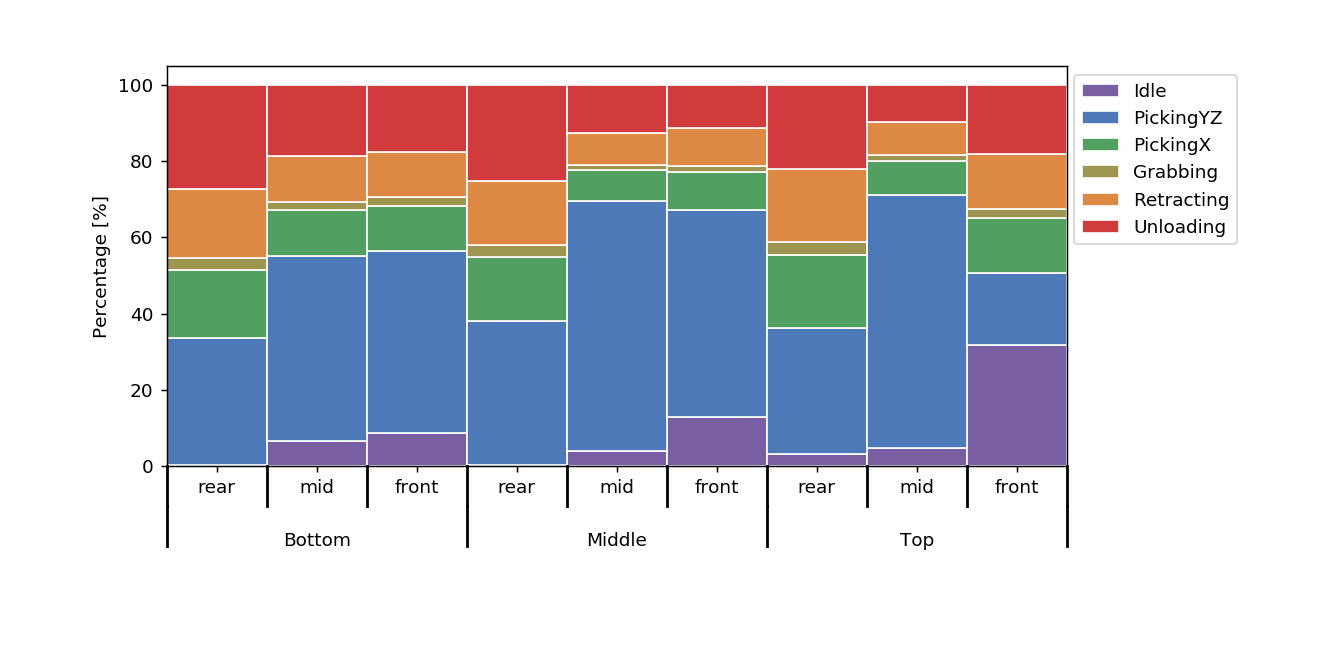

In [16]:
# % stacked bar plot
## https://chrisalbon.com/python/data_visualization/matplotlib_percentage_stacked_bar_plot/

data = {'Bottom':
           {'rear':0,
            'mid':1,
            'front':2
           },
#         'Middle Bt':
#            {'rear':0,
#             'mid':1,
#             'front':2
#            },
#         'Middle Top':
#            {'rear':0,
#             'mid':1,
#             'front':2
#            },
        'Middle':
           {'rear':0,
            'mid':1,
            'front':2
           },
        'Top':
           {'rear':0,
            'mid':1,
            'front':2
           },
       }



# Create a figure with a single subplot
f, ax = plt.subplots(1, figsize=(10,5))

# Set bar width at 1
bar_width = 1

# positions of the left bar-boundaries
bar_l = [i for i in range(1,len(idle_plot)+1)] 

# positions of the x-axis ticks (center of the bars as bar labels)
tick_pos = [i+(bar_width/2) for i in bar_l] 
# print(tick_pos)

# Create the total steps per state
totals = [i+j+k+l+m+n for i,j,k,l,m,n in zip(idle_plot, pickyz_plot, pickx_plot, grab_plot, retr_plot, unlo_plot)]

# Create the percentage of the total steps for idle state
per_idle = [i / j * 100 for  i,j in zip(idle_plot, totals)]
# Create the percentage of the total steps for pickingyz state
per_pickyz = [i / j * 100 for  i,j in zip(pickyz_plot, totals)]
# Create the percentage of the total steps for pickingx state
per_pickx = [i / j * 100 for  i,j in zip(pickx_plot, totals)]
# Create the percentage of the total steps for grabbing state
per_grab = [i / j * 100 for  i,j in zip(grab_plot, totals)]
# Create the percentage of the total steps for retracting state
per_retr = [i / j * 100 for  i,j in zip(retr_plot, totals)]
# Create the percentage of the total steps for unloading state
per_unlo = [i / j * 100 for  i,j in zip(unlo_plot, totals)]

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       # using idle data
       per_idle, 
       # labeled 
       label='Idle', 
       # with alpha
       alpha=0.9, 
       # with color
       color='#6B4C9A',
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

ax.bar(bar_l, 
       # using picking data
       per_pickyz, 
       # with per_idle
       bottom=per_idle, 
       # labeled 
       label='PickingYZ', 
       # with alpha
       alpha=0.9, 
       # with color
       color='#396AB1', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

ax.bar(bar_l, 
       # using picking data
       per_pickx, 
       # with per_idle
       bottom=[i+j for i,j in zip(per_idle, per_pickyz)], 
       # labeled 
       label='PickingX', 
       # with alpha
       alpha=0.9, 
       # with color
       color='#3E9651', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

ax.bar(bar_l, 
       # using picking data
       per_grab, 
       # with per_idle
       bottom=[i+j+k for i,j,k in zip(per_idle, per_pickyz, per_pickx)], 
       # labeled 
       label='Grabbing', 
       # with alpha
       alpha=0.9, 
       # with color
       color='#948B3D', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       # using retracting data
       per_retr, 
       # with per_idle and per_pick on bottom
       bottom=[i+j+k+l for i,j,k,l in zip(per_idle, per_pickyz, per_pickx, per_grab)], 
       # labeled 
       label='Retracting',
       # with alpha
       alpha=0.9, 
       # with color
       color='#DA7C30', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       # using retracting data
       per_unlo, 
       # with all other percents on bottom
       bottom=[i+j+k+l+m for i,j,k,l,m in zip(per_idle, per_pickyz, per_pickx, per_grab, per_retr)], 
       # labeled 
       label='Unloading',
       # with alpha
       alpha=0.9, 
       # with color
       color='#CC2529', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )


ax.set_ylabel("Percentage [%]")

# grouping x-axis values
label_group_bar(ax, data)
f.subplots_adjust(bottom=0.3, top=0.9, right=0.8)
# f.subplots_adjust()

# rotate axis labels
# plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')

# create legend outside of plot
# see https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot/43439132#43439132
ax.legend(bbox_to_anchor=(1.2, 1), loc='upper right', ncol=1)

# shot plot
plt.show()

num runs 52001


<IPython.core.display.Javascript object>


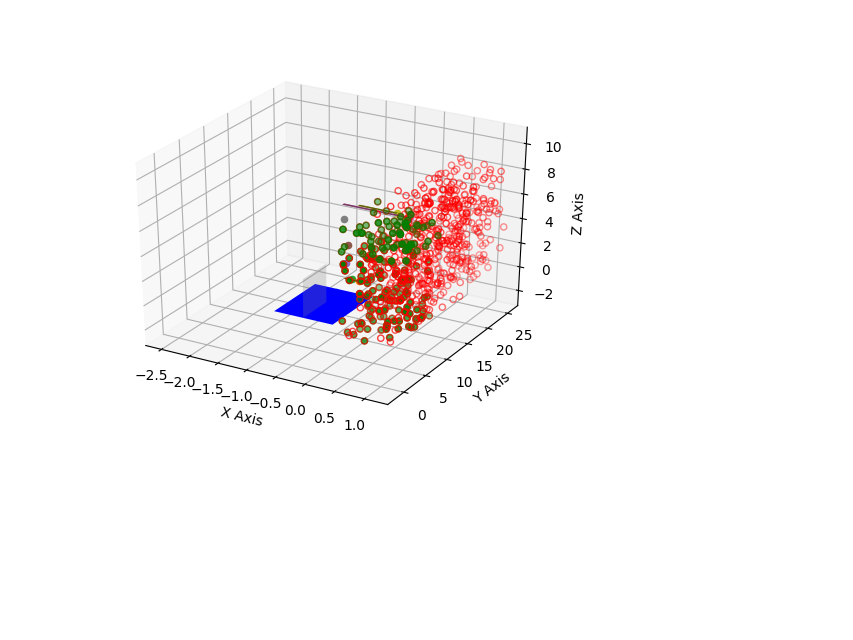

KeyboardInterrupt: 

In [22]:
## plot the vehicle's movement (add other parts as they get finished)    
print("num runs", sim.runs)

dr = drawRobot()

fruit_removal = []
index_rem = []

for rows in range(sim.num_row):
    fruit_removal.append(sim.row_picture[rows].packFruit()) # matrix of picked fruit coordinates and time of picking
    # need to have a list that indexes which fruit each row is to remove when plotting
    index_rem.append(0)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.ion() 

fig.show()
fig.canvas.draw()

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

for run in range(sim.runs):
    time_of_loop = sim.t[run]
    
    if run % 60 == 0:
        ax.clear()
        
        for rows in range(sim.num_row):
            # check if any fruit was picked at this time
            try:        
                # is the if needed when there is a try? => yup, otherwise the points appear at random times
                if fruit_removal[rows][3, index_rem[rows]] < time_of_loop:
                    # add the fruit index to be "removed"
                    index_rem[rows] += 1
            except IndexError:
                print("** Index grew faster than it should have? **")
                print("Index to remove:", index_rem[rows], "in row:", rows, "time:", time_of_loop)
                print("current time value of fruit_removal:", fruit_removal[rows][3, index_rem[rows]-1])
        
        ax.scatter(sim.fruit.sortedFruit[0,:], sim.fruit.sortedFruit[1,:], sim.fruit.sortedFruit[2,:], facecolors='none', edgecolors='r')
        
        for rows in range(sim.num_row):
            ax.scatter(fruit_removal[rows][0,:index_rem[rows]], fruit_removal[rows][1,:index_rem[rows]], fruit_removal[rows][2,:index_rem[rows]], c='g', marker='o')
            
        q_vehicle = [sim.qv0[run], sim.qv1[run]]
        dr.drawRect(ax, q_vehicle, sim.width_v, sim.length_v) # try and draw the vehicle moving along the orchard
        dr.drawFrame(ax, sim.left_edge[run], sim.back_edge[run], sim.front_edge[run], sim.arm_obj[0,0].z_edges_f)
    
        # draw cyliders for the extending arms
        for rows in range(sim.num_row):
            for count in range(sim.num_arms):
                ax.scatter(sim.arm_obj[rows,count].qax[run], sim.arm_obj[rows,count].qay[run], sim.arm_obj[rows,count].qaz[run])
                # need to switch this to a cylinder
                xc, yc, zc = dr.drawArmCylinder(sim.arm_obj[rows,count].qay[run], sim.arm_obj[rows,count].qaz[run], sim.arm_obj[rows,count].q_f[0], sim.arm_obj[rows,count].qax[run])
                ax.plot_surface(xc, yc, zc)


        ax.set_xlim(sim.fruit_row_ed-3, sim.fruit_row_tk)
        ax.set_zlim(sim.fruit_row_bt-3, sim.fruit_row_tp+2)
        
        ax.set_ylim(sim.fruit_row_st-3, sim.fruit_row_end+2)
        
        ax.set_xlabel('X Axis')
        ax.set_ylabel('Y Axis')
        ax.set_zlabel('Z Axis')

        fig.canvas.draw()
        time.sleep(0.005)
       
    
fig.show()

